In [2]:
import pandas as pd
stockprices = pd.read_csv("AAPL.csv", index_col="Date")

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["Close"]]
test = stockprices[train_size:][["Close"]]

train_size: 201
test_size: 50


In [15]:
def extract_seqX_outcomeY(data, offset):
    """
    Split time-series into training sequence X and the next output value Y
    Args:
        data - dataset (numpy array or list)
        offset - position to start the split
    Returns:
        X - training sequences
        y - corresponding next output values
    """
    N = 50  # Number of values in each training sequence
    X, y = [], []

    for i in range(offset, len(data) - N):  # Adjust range to stop before end of data
        X.append(data[i : i + N])  # Adjust slicing to include the next N values
        y.append(data[i + N])  # Append the next value after the sequence

    return np.array(X), np.array(y)


In [16]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape



In [17]:
def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )

    ## Log to Neptune
    run["RMSE"] = rmse
    run["MAPE (%)"] = mape

    return rmse, mape

In [18]:
def plot_stock_trend(var, cur_title, stockprices=stockprices):
    ax = stockprices[["Close", var, "200day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

    ## Log to Neptune
    run["Plot of Stock Predictions"].upload(
        neptune.types.File.as_image(ax.get_figure())
    )

In [23]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load data from CSV file
data = pd.read_csv("AAPL.csv")

# Assuming you have prepared your data and split it into train and test sets
train_data = data["Close"].values[:-50]  # Use all data except the last 50 points for training
test_data = data["Close"].values[-50:]   # Use the last 50 points for testing

# Train an ARIMA model (example)
model = ARIMA(train_data, order=(1, 1, 1))  # Example ARIMA model with order (p, d, q)
model_fit = model.fit()

# Generate predictions for the test set
y_pred = model_fit.forecast(steps=50)  # Predict the next 50 values

# Now, y_pred contains the predicted values for the test set


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Load data from CSV file
data = pd.read_csv("AAPL.csv")

# Assuming you have prepared your data and split it into train and test sets
X = data.drop(columns=["Date", "Close"])  # Features (excluding Date and Close columns)
y = data["Close"]  # Target variable (Close prices)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a forecasting model
model = RandomForestRegressor(random_state=42)  # Example model (Random Forest Regressor)
model.fit(X_train, y_train)

# Step 3: Generate predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)


RMSE: 0.4533038338247795
MAPE: 0.17547468098907795


In [25]:
def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )

    ## Log to Neptune
    run["RMSE"] = rmse
    run["MAPE (%)"] = mape

    return rmse, mape

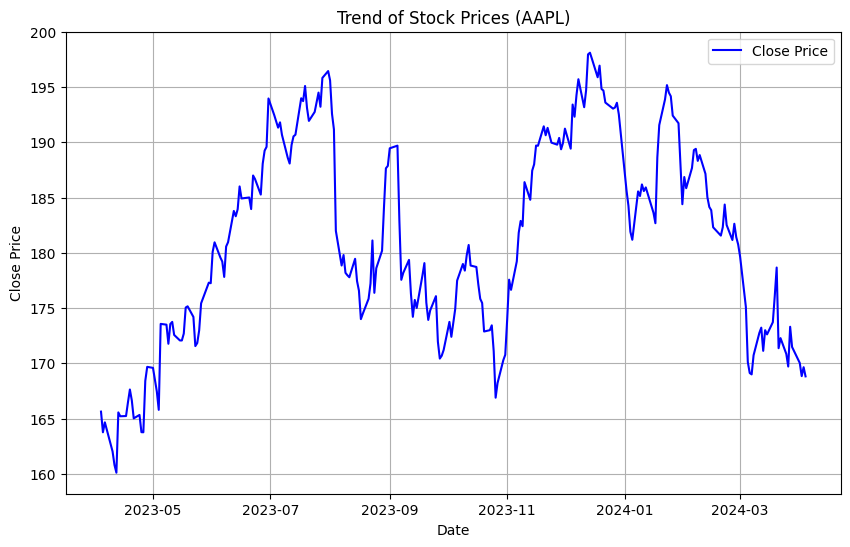

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv("AAPL.csv")

# Convert the "Date" column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Set "Date" column as the index
data.set_index("Date", inplace=True)

# Plot the trend of the closing prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close"], color="blue", label="Close Price")
plt.title("Trend of Stock Prices (AAPL)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


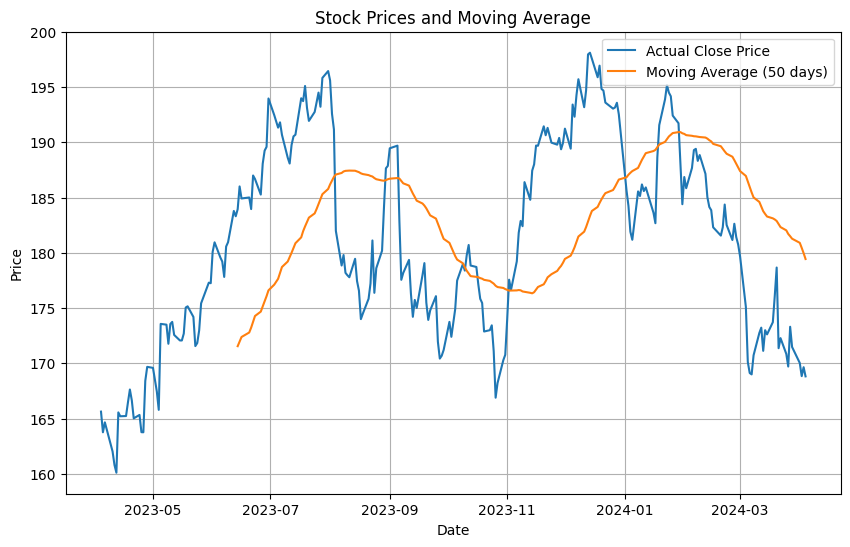

Predicted value for the next day: nan


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical stock price data from CSV file
data = pd.read_csv("AAPL.csv")

# Convert the "Date" column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Calculate the moving average over a specified time period (e.g., 50 days)
window_size = 50
data["MovingAverage"] = data["Close"].rolling(window=window_size).mean()

# Make predictions for future stock prices using the moving average
predictions = data["MovingAverage"].shift(-1)

# Plot the original stock prices and the moving average
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], data["Close"], label="Actual Close Price")
plt.plot(data["Date"], data["MovingAverage"], label=f"Moving Average ({window_size} days)")
plt.title("Stock Prices and Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print the last predicted value
print("Predicted value for the next day:", predictions.iloc[-1])


In [55]:
import pandas as pd

# Load the dataset
data = pd.read_csv("AAPL.csv")

# Compute mean, median, and standard deviation
mean_price = data["Close"].mean()
median_price = data["Close"].median()
std_deviation = data["Close"].std()

# Print the computed statistics
print("Mean Price:", mean_price)
print("Median Price:", median_price)
print("Standard Deviation:", std_deviation)


Mean Price: 180.92023837698412
Median Price: 180.640007
Standard Deviation: 9.172632178628193


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data from CSV file
data = pd.read_csv("AAPL.csv")

# Select relevant features
features = ["Open", "High", "Low", "Close"]

# Prepare X (features) and y (target)
X = data[features]
y = data["Volume"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optionally, make predictions on new data
# new_data = ...  # Load new data
# new_predictions = model.predict(new_data)


Mean Squared Error: 119887963386474.38


In [58]:
# %% Train-Test split for time-series
stockprices = pd.read_csv("AAPL.csv", index_col="Date")

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["Close"]]
test = stockprices[train_size:][["Close"]]

train_size: 201
test_size: 50


In [59]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)


In [60]:
import pandas as pd
import numpy as np

# Load the data from the CSV file
data = pd.read_csv("AAPL.csv")

# Assuming your CSV has a column named 'Close' for the stock prices
# You can change 'Close' to the appropriate column name if needed
prices = data['Close'].values

def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Example usage:
# Assuming 'prices' is your stock prices data
n_steps = 10  # Adjust as needed
X, y = split_sequence(prices, n_steps)

print("X shape:", X.shape)
print("Y shape:", y.shape)



X shape: (242, 10)
Y shape: (242,)
